# Project Goals---

#### - Find users that are going to churn in future?
#### - What factors drive users to churn?

In [78]:
#importing libraries
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm #logistic regression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV #hyperparamter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import warnings; warnings.simplefilter('ignore')

In [3]:
#meta-data
v_dict = {"city": "city this user signed up in","phone": "primary device for this user","signup_date": "date of account registration; in the form `YYYYMMDD`",
"last_trip_date": "the last time this user completed a trip; in the form `YYYYMMDD`","avg_dist": "the average distance (in miles) per trip taken in the first 30 days after signup",
"avg_rating_by_driver": "the rider’s average rating over all of their trips","avg_rating_of_driver": "the rider’s average rating of their drivers over all of their trips", 
"surge_pct": "the percent of trips taken with surge multiplier > 1","avg_surge": "The average surge multiplier over all of this user’s trips", 
"trips_in_first_30_days": "the number of trips this user took in the first 30 days after signing up","luxury_car_user": "TRUE if the user took a luxury car in their first 30 days; FALSE otherwise",
"weekday_pct": "the percent of the user’s trips occurring during a weekday"}

In [4]:
#meta data information
pd.set_option('display.max_colwidth',-1)
pd.DataFrame(list(v_dict.items()),columns = ["variable","description"])

,variable,description
0,city,city this user signed up in
1,phone,primary device for this user
2,signup_date,date of account registration; in the form `YYYYMMDD`
3,last_trip_date,the last time this user completed a trip; in the form `YYYYMMDD`
4,avg_dist,the average distance (in miles) per trip taken in the first 30 days after signup
5,avg_rating_by_driver,the rider’s average rating over all of their trips
6,avg_rating_of_driver,the rider’s average rating of their drivers over all of their trips
7,surge_pct,the percent of trips taken with surge multiplier > 1
8,avg_surge,The average surge multiplier over all of this user’s trips
9,trips_in_first_30_days,the number of trips this user took in the first 30 days after signing up


In [5]:
#loading data
data = pd.read_csv("C:/Users/pares/OneDrive/Documents/assessments/churn prediction/churn.csv")
data.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
avg_dist,3.67,8.26,0.77,2.36,3.13,10.56,3.95,2.04,4.36,2.37
avg_rating_by_driver,5,5,5,4.9,4.9,5,4,5,5,5
avg_rating_of_driver,4.7,5,4.3,4.6,4.4,3.5,NaN,5,4.5,NaN
avg_surge,1.1,1,1,1.14,1.19,1,1,1,1,1
city,King's Landing,Astapor,Astapor,King's Landing,Winterfell,Winterfell,Astapor,Winterfell,Winterfell,Winterfell
last_trip_date,2014-06-17,2014-05-05,2014-01-07,2014-06-29,2014-03-15,2014-06-06,2014-01-25,2014-01-29,2014-02-01,2014-01-05
phone,iPhone,Android,iPhone,iPhone,Android,iPhone,Android,iPhone,Android,Android
signup_date,2014-01-25,2014-01-29,2014-01-06,2014-01-10,2014-01-27,2014-01-09,2014-01-24,2014-01-28,2014-01-21,2014-01-03
surge_pct,15.4,0,0,20,11.8,0,0,0,0,0
trips_in_first_30_days,4,0,3,9,14,2,1,2,2,1


In [6]:
#Available Information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


## Insights --
- Each row is a unique customer - we have data on 50,000 customers
- 3 columns with missing values (avg_rating_by_driver; avg_rating_of_driver; phone)
- 2 categorical columns (phone; city); 
- 2 date columns (need to converted into correct data type)
- 1 boolean variable
- 7 numerical variables

## Before, we start diving into the data, what should we expect intuitively?

- Riders who did not have a good experience might leave/stop using the app - avg_rating_of_driver should indicate that.

- Customers experiencing high surge are likely to leave. High avg_surge and surge_pct should indicate that.

- Avg_dist; trips_in_first_30_days are values taken for only first 30 days since sign_up. Therefore, it should be low since, customers usually take cabs for short distances, and are unlikely to take a cab every day (values should be below 30!)

In [7]:
#Lets first convert columns to their appropriate data types
data.signup_date = data.signup_date.astype('datetime64')
data.last_trip_date = data.last_trip_date.astype("datetime64")

#### We need a response variable -- 

In [8]:
print("------Last trip date decription-------")
print()
print(data.last_trip_date.describe())
print()
print("------Sign up date decription-------")
print()
print(data.signup_date.describe())

------Last trip date decription-------

count     50000              
unique    182                
top       2014-06-29 00:00:00
freq      2036               
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

------Sign up date decription-------

count     50000              
unique    31                 
top       2014-01-18 00:00:00
freq      2948               
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object


- So looks like, users signed up in January and have used the app till 1st of July, 2014.
- To create the target variable, we need to determine which users are active, and who have stopped using the application. Lets see the breakdown by each month

In [9]:
#Lets see the breakdown by months
last_trip_bd = data.groupby(data['last_trip_date'].dt.strftime('%B')).last_trip_date.count()
cats = ['January', 'February', 'March', 'April','May','June', 'July', 'August','September', 'October', 'November', 'December']
last_trip_bd.index = pd.CategoricalIndex(last_trip_bd.index, categories=cats, ordered=True)
last_trip_bd = last_trip_bd.sort_index()
last_trip_bd

last_trip_date
January     10147
February    4308 
March       4568 
April       4588 
May         7585 
June        18256
July        548  
Name: last_trip_date, dtype: int64

- Clearly, users who have used the app in July and June, are customers who are still loyal to the company. However, customers who last used the app before June (in May or before) have gone by without using the app for a considerable time. Lets mark them as inactive (or users who have churned).

In [10]:
#Any user whose last trip with the company was before 1st June, 2014 is considered to be "churned". 
data["churned"] = 1
data["churned"][data.last_trip_date >= "2014-06-01"] = 0
data.churned = data.churned.astype("category")

C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Duplicated values

In [11]:
data[data.duplicated()].shape

(8, 13)

Although, we dont have a unique customer ID for each customer, having all values similar looks highly unlikely for 2 customers. There are 8 such rows in the data (customer having the same city, same phone, same signup_date, same last_trip_date looks highly unlikely)

In [12]:
data.drop_duplicates(inplace = True)

#### How many missing values are there?

In [13]:
data.isnull().sum()

avg_dist                  0   
avg_rating_by_driver      201 
avg_rating_of_driver      8119
avg_surge                 0   
city                      0   
last_trip_date            0   
phone                     396 
signup_date               0   
surge_pct                 0   
trips_in_first_30_days    0   
luxury_car_user           0   
weekday_pct               0   
churned                   0   
dtype: int64

- Why does column "phone" have missing values? (Need further look)
- Having missing values for ratings seem intuitive. Not all customers provide a rating to the drivers. Similar for Drivers.

#### What is the distribution for our response variable?

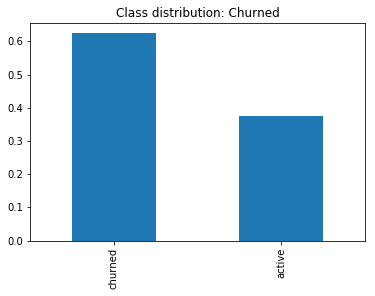

In [14]:
data.churned.value_counts(normalize = True).plot(kind = "bar",title = "Class distribution: Churned")
plt.xticks(np.arange(2),labels = ["churned","active"])
plt.show()

- the class distribution is almost 60/40. This is not ideal, but doesn't require us to upsample/downsample our data points, in other terms, THIS IS OKAY!

#### Distribution of Individual Variables

In [15]:
#Separating columns by data types
def separate(df):
    separated_cols = {
        "categorical" : list(df.select_dtypes(include = ["bool","object","category"]).columns),
        "continuous" : list(df.select_dtypes(include = ["int64","float64"]).columns),
        "date" : list(df.select_dtypes(include = ["datetime"]).columns)
    }
    return separated_cols

separate(data)

{'categorical': ['city', 'phone', 'luxury_car_user', 'churned'],
 'continuous': ['avg_dist',
  'avg_rating_by_driver',
  'avg_rating_of_driver',
  'avg_surge',
  'surge_pct',
  'trips_in_first_30_days',
  'weekday_pct'],
 'date': ['last_trip_date', 'signup_date']}

#### Categorical Variables

In [16]:
cat_cols = separate(data)["categorical"]
cat_cols.remove("churned")
cat_cols

['city', 'phone', 'luxury_car_user']

,city,phone,luxury_car_user
count,49992,49596,49992
unique,3,2,2
top,Winterfell,iPhone,False
freq,23331,34578,31141


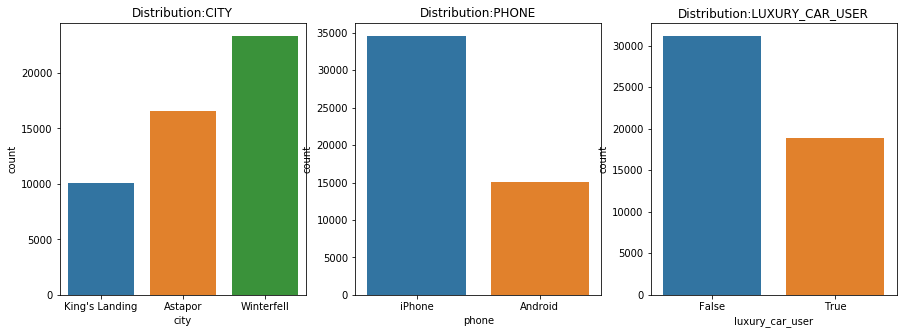

In [17]:
fig, ax= plt.subplots(1,3, figsize = (15,5))
for i, col in enumerate(cat_cols):
    sns.countplot(x = col,data = data, ax = ax[i])
    ax[i].set_title("Distribution:"+ col.upper())
data[cat_cols].describe()

#### Numerical Variables

In [18]:
cont_cols = separate(data)["continuous"]
data[cont_cols].describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,49992.00000,49791.000000,41873.000000,49992.000000,49992.000000,49992.000000,49992.000000
mean,5.79726,4.778123,4.601512,1.074776,8.850952,2.278405,60.929833
std,5.70761,0.446679,0.617360,0.222352,19.960094,3.792953,37.078229
min,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.42000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.88000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.94000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.96000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


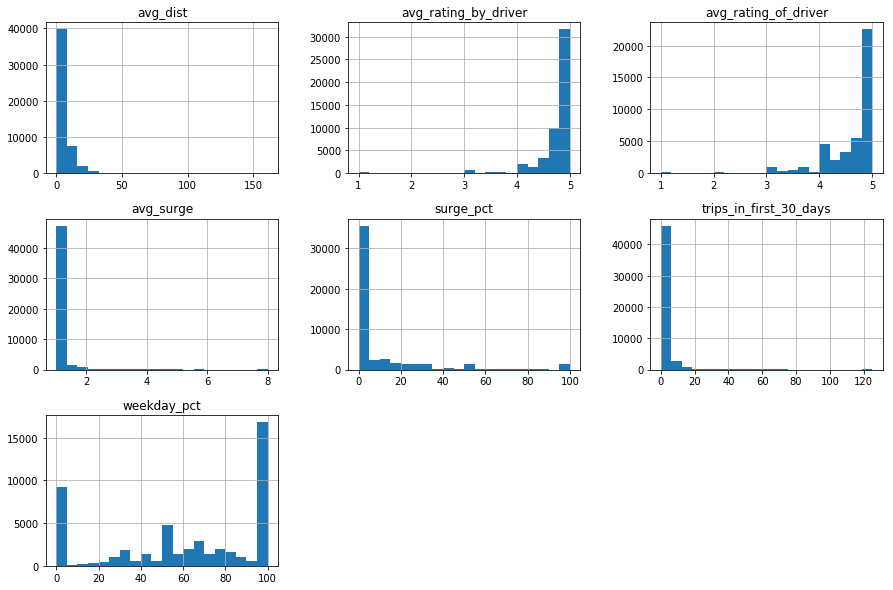

In [19]:
data[cont_cols].hist(figsize = (15,10),bins = 20)
plt.show()

### Insights
- Almost all varibales are skewed. We need to transform them.
- Can convert avg_ratings into a categorical variable (Not much of a difference between 4.5 and 4.9 ratings. Both indicate, customer/driver is a good driver!)
- Avg_dist = distance travelled in the first 30 days. Need to look at outlier points. Travelling more than 50 miles in 1 month seems really odd.
- Avg_surge = 50th percentile value is also 1. Majority of the values seems to be 1. Similarly for surge_pct, majority values are 0.0. Might be some correlation between the two variables. Need a closer look. We can create categories here. Users riding all rides with surge/ no rides with surge/ some rides with surge.
- Trips_in_first_30_days = Intuitvely, this should be low. There can be correlation between avg_dist and trips taken. Trips greater than 40/50 in 1 month is very strange.
- Weekday_pct = Except 0 and 100.0 values, the distribution looks like a normal distribution. We can create a categorical variable here, users who rode all their rides on weekday/no rides/ and some rides.

## Outliers

#### - Missing phone values

In [20]:
missing_phone = data[data.phone.isnull()]

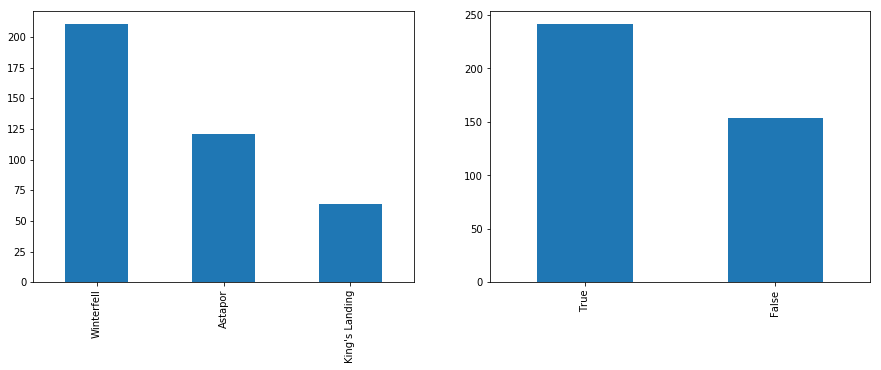

In [21]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
missing_phone["city"].value_counts().plot(kind= "bar", ax = ax[0])
missing_phone["luxury_car_user"].value_counts().plot(kind= "bar", ax = ax[1])
plt.show()

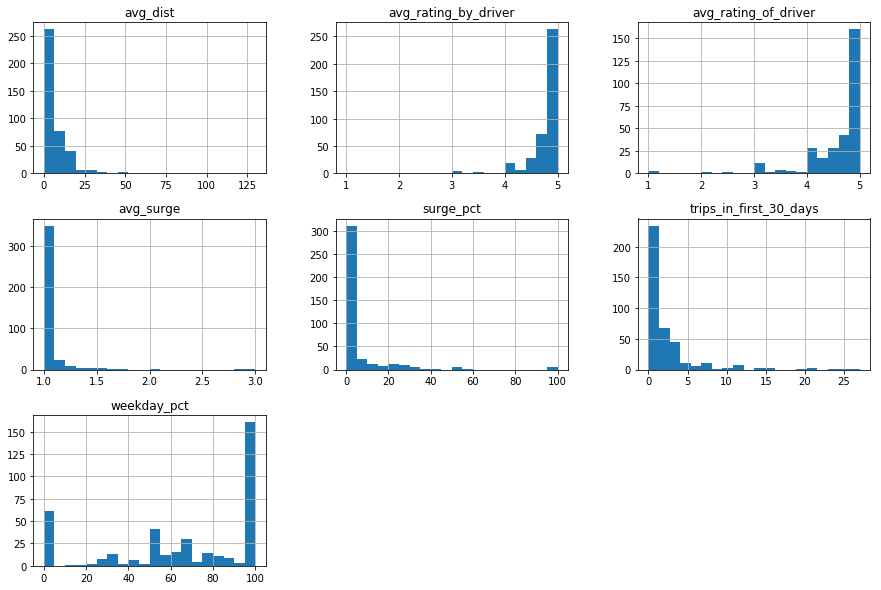

In [22]:
missing_phone[separate(missing_phone)["continuous"]].hist(figsize = (15,10),bins=20)
plt.show()

- Everything looks similar except luxury_car_user. The distribution of the variable is opposite for customers having missing phone values

In [23]:
data["phone"] = data["phone"].fillna("Unknown")
data.groupby(["phone","luxury_car_user"]).size().reset_index().pivot(index = "phone",columns = "luxury_car_user",values = 0)

luxury_car_user,False,True
phone,,
Android,10196,4822
Unknown,154,242
iPhone,20791,13787


- Seems like missing values for phone implies, the phone was other than android and iPhone. Lets convert that as "Other".

In [24]:
data.phone[data["phone"] == "Unknown"] = "Other"

C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### - Average_distance greater than 80 miles

In [25]:
#Total customers
data[data["avg_dist"] > 80].shape

(2, 13)

In [26]:
data[data["avg_dist"] > 80]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churned
534,129.89,5.0,NaN,1.0,King's Landing,2014-03-09,Other,2014-01-04,0.0,0,False,0.0,1
20701,160.96,NaN,NaN,1.0,Astapor,2014-06-26,Android,2014-01-25,0.0,0,False,100.0,0


Technically, if the trips_in_first_30_days is 0, then avg_dist per trip in the first 30 days should also be 0. Why are there values greater than 0?

In [27]:
data[(data.avg_dist > 0) & (data.trips_in_first_30_days == 0)].shape

(15334, 13)

Woah! There are 15,000 such customers (thats 30% of observations)
- Something, definitely is wrong here. Given the variable description, either, the avg_dist is reported wrong or trips_in_first_30_days is not correct.
- Lets make all such values for avg_dist 0.0.

In [28]:
data["avg_dist_misreported"]= 0
data["avg_dist_misreported"][(data.avg_dist >0) & (data.trips_in_first_30_days == 0)] = 1

C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
data.avg_dist[(data.avg_dist > 0) & (data.trips_in_first_30_days == 0)] = 0.0

C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
data[data.avg_dist > 50].head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churned,avg_dist_misreported
1302,79.69,5.0,5.0,1.0,Winterfell,2014-01-30,iPhone,2014-01-30,0.0,1,False,100.0,1,0
1482,52.15,4.0,NaN,1.0,King's Landing,2014-01-10,Android,2014-01-08,0.0,1,False,100.0,1,0
1493,72.08,5.0,5.0,1.0,Astapor,2014-01-27,iPhone,2014-01-26,0.0,1,False,100.0,1,0
2063,51.52,4.0,5.0,1.0,Winterfell,2014-01-11,iPhone,2014-01-08,0.0,2,True,100.0,1,0
8110,62.14,5.0,5.0,1.0,Winterfell,2014-01-18,Android,2014-01-18,0.0,1,True,0.0,1,0
9347,52.10,5.0,4.0,1.0,Winterfell,2014-01-15,iPhone,2014-01-14,0.0,1,False,100.0,1,0
14411,53.85,2.0,5.0,1.0,King's Landing,2014-01-26,Android,2014-01-26,0.0,1,False,0.0,1,0
18673,61.45,5.0,NaN,1.0,King's Landing,2014-02-07,iPhone,2014-01-23,0.0,1,True,100.0,1,0
18824,63.15,5.0,NaN,1.0,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0,1,0
18987,56.53,5.0,5.0,1.0,Winterfell,2014-01-22,iPhone,2014-01-20,0.0,1,False,100.0,1,0


- All of these churned! Looks like these are the customers, who signed up, took a ride and then never used the app again. Nothing seems to be mis-reported here.


#### Average Surge greater than 2

In [31]:
#Observations equal to 1.0 surge
data[data.avg_surge == 1].shape

(34446, 14)

In [32]:
data.avg_surge.unique()

array([1.1 , 1.  , 1.14, 1.19, 1.38, 1.21, 1.17, 1.02, 1.05, 1.5 , 2.  ,
       1.25, 1.04, 1.88, 1.33, 1.56, 1.06, 1.03, 1.09, 1.35, 3.5 , 1.11,
       1.63, 2.5 , 1.32, 1.3 , 1.75, 2.25, 1.2 , 1.13, 1.08, 1.15, 4.  ,
       1.12, 1.22, 1.29, 1.23, 1.01, 1.07, 1.18, 1.45, 2.75, 2.63, 1.46,
       2.07, 1.27, 3.  , 1.36, 1.96, 1.42, 1.44, 1.54, 1.16, 1.31, 1.58,
       1.92, 1.67, 1.26, 4.75, 1.41, 3.25, 1.24, 2.13, 1.6 , 1.57, 1.34,
       1.52, 1.69, 5.  , 1.4 , 1.37, 1.7 , 1.78, 1.43, 1.94, 1.64, 1.83,
       1.28, 1.85, 1.55, 1.48, 1.39, 2.88, 4.25, 1.47, 1.51, 1.9 , 1.68,
       4.5 , 1.66, 2.33, 1.65, 1.71, 2.17, 2.38, 1.61, 2.08, 3.75, 8.  ,
       1.77, 1.49, 2.42, 1.59, 1.8 , 2.19, 1.53, 1.81, 5.75, 1.79, 2.44,
       2.67, 2.31, 2.1 , 2.2 , 3.63])

All the values are rounded upto 2 decimal places. 

In [33]:
print("All obervations greater than 2.0 surge = ",data[data.avg_surge > 2].shape)
data[data.avg_surge > 2].head(10)

All obervations greater than 2.0 surge =  (467, 14)


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churned,avg_dist_misreported
81,17.89,4.0,4.0,3.50,Winterfell,2014-02-05,Android,2014-01-25,100.0,1,True,100.0,1,0
119,4.14,5.0,NaN,2.50,Astapor,2014-01-12,Android,2014-01-11,100.0,1,False,0.0,1,0
197,0.00,5.0,3.7,2.25,Winterfell,2014-03-02,iPhone,2014-01-08,66.7,0,False,33.3,1,1
274,6.00,NaN,2.0,4.00,Astapor,2014-02-09,iPhone,2014-01-25,100.0,1,False,0.0,1,0
448,0.00,5.0,5.0,2.75,Astapor,2014-03-19,Android,2014-01-27,100.0,0,False,100.0,1,1
461,3.45,5.0,4.0,2.63,Astapor,2014-01-26,iPhone,2014-01-24,100.0,2,False,50.0,1,0
497,2.64,4.3,4.4,2.07,Winterfell,2014-06-10,iPhone,2014-01-25,71.4,6,True,57.1,0,0
527,3.18,5.0,NaN,3.00,Astapor,2014-01-26,iPhone,2014-01-25,100.0,1,False,0.0,1,0
662,14.91,5.0,NaN,2.50,Winterfell,2014-01-02,iPhone,2014-01-02,100.0,1,True,100.0,1,0
958,3.77,5.0,NaN,2.25,King's Landing,2014-01-26,iPhone,2014-01-25,100.0,1,False,0.0,1,0


In [34]:
print("All obervations greater than 4.0 surge = ",data[data.avg_surge > 4].shape)
data[data.avg_surge > 4]

All obervations greater than 4.0 surge =  (17, 14)


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churned,avg_dist_misreported
1405,6.46,5.0,5.0,4.75,Winterfell,2014-01-21,iPhone,2014-01-08,100.0,1,False,100.0,1,0
2817,0.00,5.0,5.0,5.00,Winterfell,2014-02-05,iPhone,2014-01-02,100.0,0,False,100.0,1,1
5355,0.69,5.0,5.0,4.25,Winterfell,2014-01-11,Android,2014-01-10,100.0,1,False,100.0,1,0
10546,0.00,5.0,NaN,4.50,Winterfell,2014-06-21,iPhone,2014-01-03,100.0,0,False,0.0,0,1
13861,5.77,5.0,1.0,8.00,Winterfell,2014-01-01,iPhone,2014-01-01,100.0,1,False,100.0,1,0
15334,0.00,5.0,NaN,4.50,Winterfell,2014-06-18,iPhone,2014-01-13,100.0,0,False,100.0,0,1
19191,3.37,5.0,5.0,5.00,Winterfell,2014-01-11,Android,2014-01-10,100.0,1,False,100.0,1,0
21742,0.00,5.0,NaN,4.50,Winterfell,2014-06-21,iPhone,2014-01-19,100.0,0,False,0.0,0,1
21894,2.46,4.0,NaN,5.00,Winterfell,2014-01-11,Android,2014-01-10,100.0,1,False,100.0,1,0
25397,0.00,5.0,NaN,4.25,Winterfell,2014-06-29,Android,2014-01-17,100.0,0,False,0.0,0,1


- Avg_surge greater than 4.0 are all happening in Winterfell. But, there are too less data points here to make any conclusion.

In [35]:
print("All obervations with surge_pct equal to 100.0 = ",data[data.surge_pct == 100].shape)
data[data.surge_pct == 100].head(10)

All obervations with surge_pct equal to 100.0 =  (1416, 14)


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churned,avg_dist_misreported
28,0.00,5.0,NaN,1.50,Winterfell,2014-06-08,iPhone,2014-01-19,100.0,0,False,0.0,0,1
32,10.01,5.0,4.0,2.00,Winterfell,2014-06-10,iPhone,2014-01-05,100.0,1,False,100.0,0,0
34,4.12,5.0,NaN,1.25,Astapor,2014-01-17,Android,2014-01-16,100.0,1,False,100.0,1,0
42,5.72,5.0,4.0,1.50,Winterfell,2014-01-26,Android,2014-01-25,100.0,1,False,0.0,1,0
47,3.61,5.0,5.0,1.25,Winterfell,2014-01-19,iPhone,2014-01-18,100.0,1,False,0.0,1,0
50,0.00,5.0,5.0,1.25,Winterfell,2014-02-15,Android,2014-01-04,100.0,0,False,0.0,1,1
59,6.05,4.5,5.0,1.25,Astapor,2014-03-29,iPhone,2014-01-25,100.0,1,False,0.0,1,0
81,17.89,4.0,4.0,3.50,Winterfell,2014-02-05,Android,2014-01-25,100.0,1,True,100.0,1,0
119,4.14,5.0,NaN,2.50,Astapor,2014-01-12,Android,2014-01-11,100.0,1,False,0.0,1,0
135,1.99,5.0,NaN,1.75,Winterfell,2014-01-18,iPhone,2014-01-17,100.0,1,False,100.0,1,0


In [36]:
#Customers churn ratio for people who took all their rides with surge higher than 1.0
data.churned[data.surge_pct == 100].value_counts(normalize = True)

1    0.84887
0    0.15113
Name: churned, dtype: float64

This variable looks really important. Customers taking rides with high surge seems to leave the company (which makes sense!)

#### Trips_in_first_30_days

In [37]:
print("All obervations with number of trips greater than 50 = ",data[data.trips_in_first_30_days>=50].shape)
data[data.trips_in_first_30_days>=50]

All obervations with number of trips greater than 50 =  (15, 14)


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churned,avg_dist_misreported
99,2.86,4.9,4.9,1.00,Astapor,2014-03-05,Android,2014-01-27,0.0,73,True,89.7,1,0
3030,2.32,4.8,4.9,1.06,Winterfell,2014-06-28,iPhone,2014-01-06,2.9,71,True,85.9,0,0
10863,2.58,4.7,4.1,1.02,Winterfell,2014-06-30,iPhone,2014-01-05,3.4,53,True,70.5,0,0
17942,3.27,4.7,4.6,1.03,Winterfell,2014-06-25,iPhone,2014-01-07,5.3,55,True,68.0,0,0
18514,2.02,4.8,5.0,1.12,King's Landing,2014-06-30,iPhone,2014-01-02,14.4,125,True,72.0,0,0
25520,6.20,4.8,4.8,1.00,Winterfell,2014-05-03,iPhone,2014-01-17,0.0,50,False,70.5,1,0
29043,3.39,4.6,4.8,1.03,King's Landing,2014-06-30,iPhone,2014-01-22,4.8,55,True,66.5,0,0
29070,1.45,4.6,4.0,1.07,Astapor,2014-06-29,iPhone,2014-01-10,7.3,63,True,83.3,0,0
31047,2.19,4.5,4.9,1.10,Winterfell,2014-06-29,iPhone,2014-01-25,9.1,54,True,83.0,0,0
33488,2.91,4.9,4.9,1.05,King's Landing,2014-07-01,iPhone,2014-01-01,6.8,54,True,70.7,0,0


- On an average, in a month,if a customer is making 2 trips per day, that equals 60 trips. Here, values greater than 60 (one customer with 125 trips is a very number!)
- 125 trips in 1 month equals almost 4 trips/day. That is a very high number for any customer.
- But nothing here suggests that these values are mis-reported. Therefore, we'll not remove them.

#### Weekday_pct

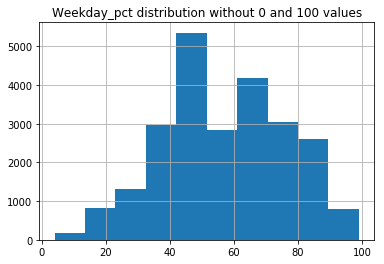

In [38]:
data.weekday_pct[(data.weekday_pct != 0.0) & (data.weekday_pct != 100)].hist()
plt.title("Weekday_pct distribution without 0 and 100 values") 
plt.show()

Slightly left skewed. But that's okay!

## Feature Engineering 

Lets look at the relationships between features

#### By City--

<Figure size 720x360 with 0 Axes>

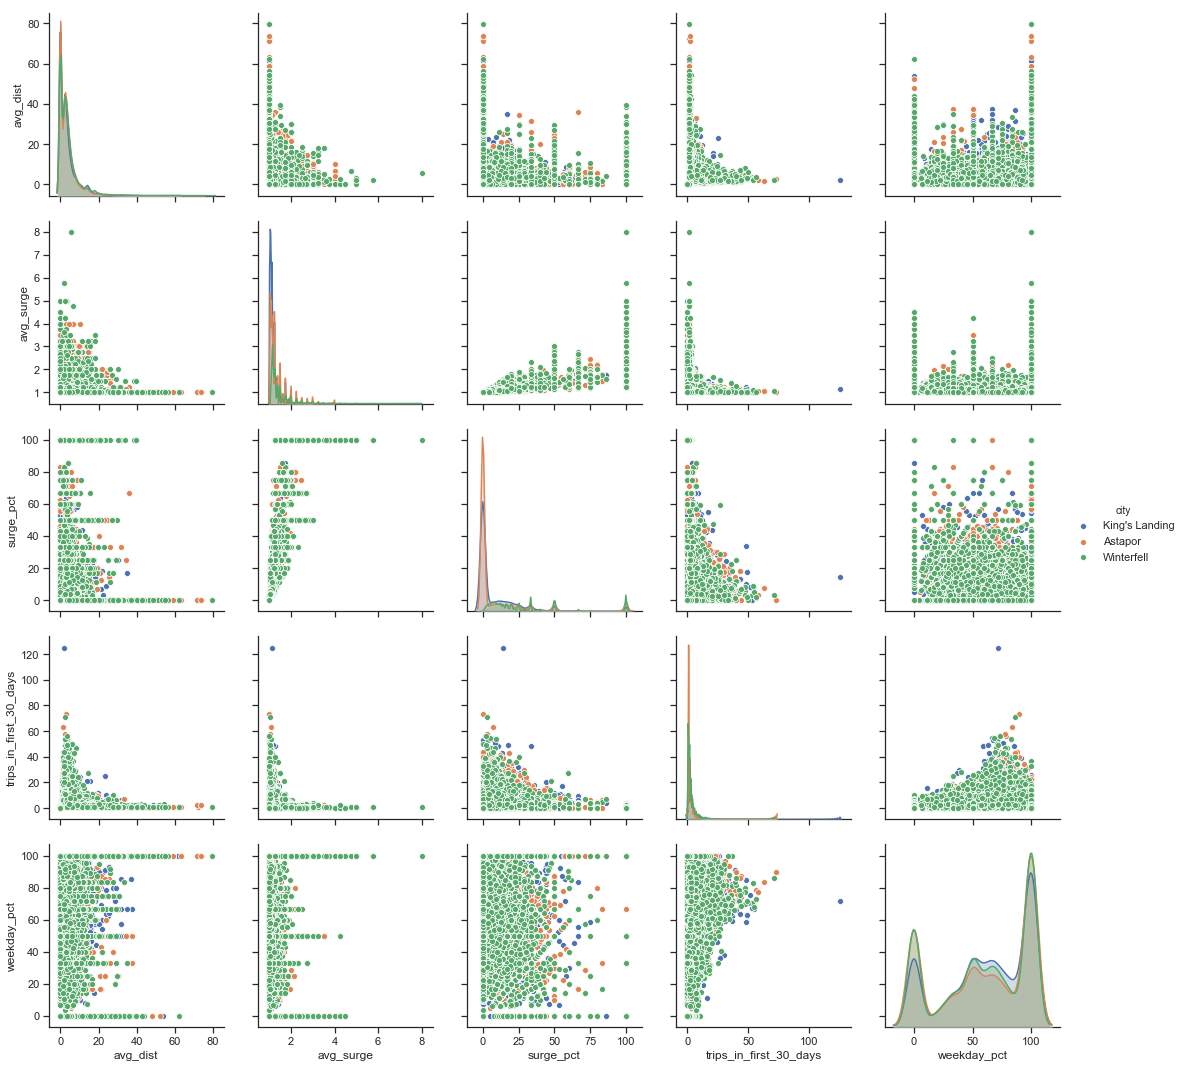

In [39]:
#Since, we convert ratings variables into categories, its better to leave them out here.
cont_cols = [i for i in cont_cols if i not in ["avg_rating_by_driver","avg_rating_of_driver"]]
sns.set(style = "ticks",color_codes = True)
cols = cont_cols[0:]
cols.append("city")
plt.figure(figsize = (10,5))
sns.pairplot(data[cols],hue = "city",height =3)
plt.show()

- No patterns as such visible

### By phone--

<Figure size 720x360 with 0 Axes>

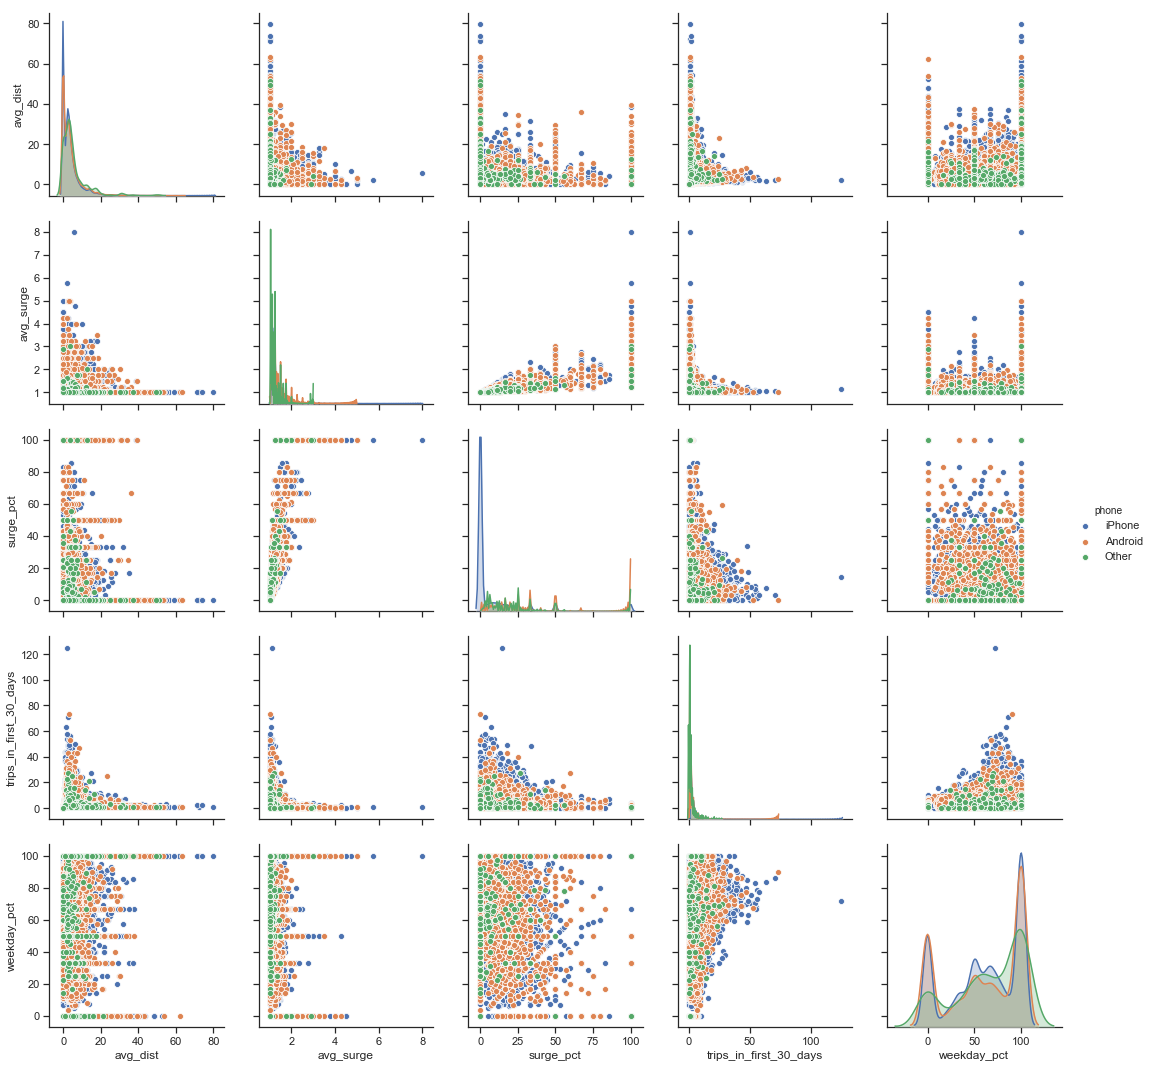

In [40]:
sns.set(style = "ticks",color_codes = True)
cols = cont_cols[0:]
cols.append("phone")
plt.figure(figsize = (10,5))
sns.pairplot(data[cols],hue = "phone",height =3)
plt.show()

- iphone users experience less surge charge. Android and Other customers have done higher % of rides with surge > 1.
- iphone users have higher number of trips in first 30 days.

-- Looks like having an iphone is advantageous as far as getting low charge rides. We can create another variable for this.

### By churned --

C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


<Figure size 720x360 with 0 Axes>

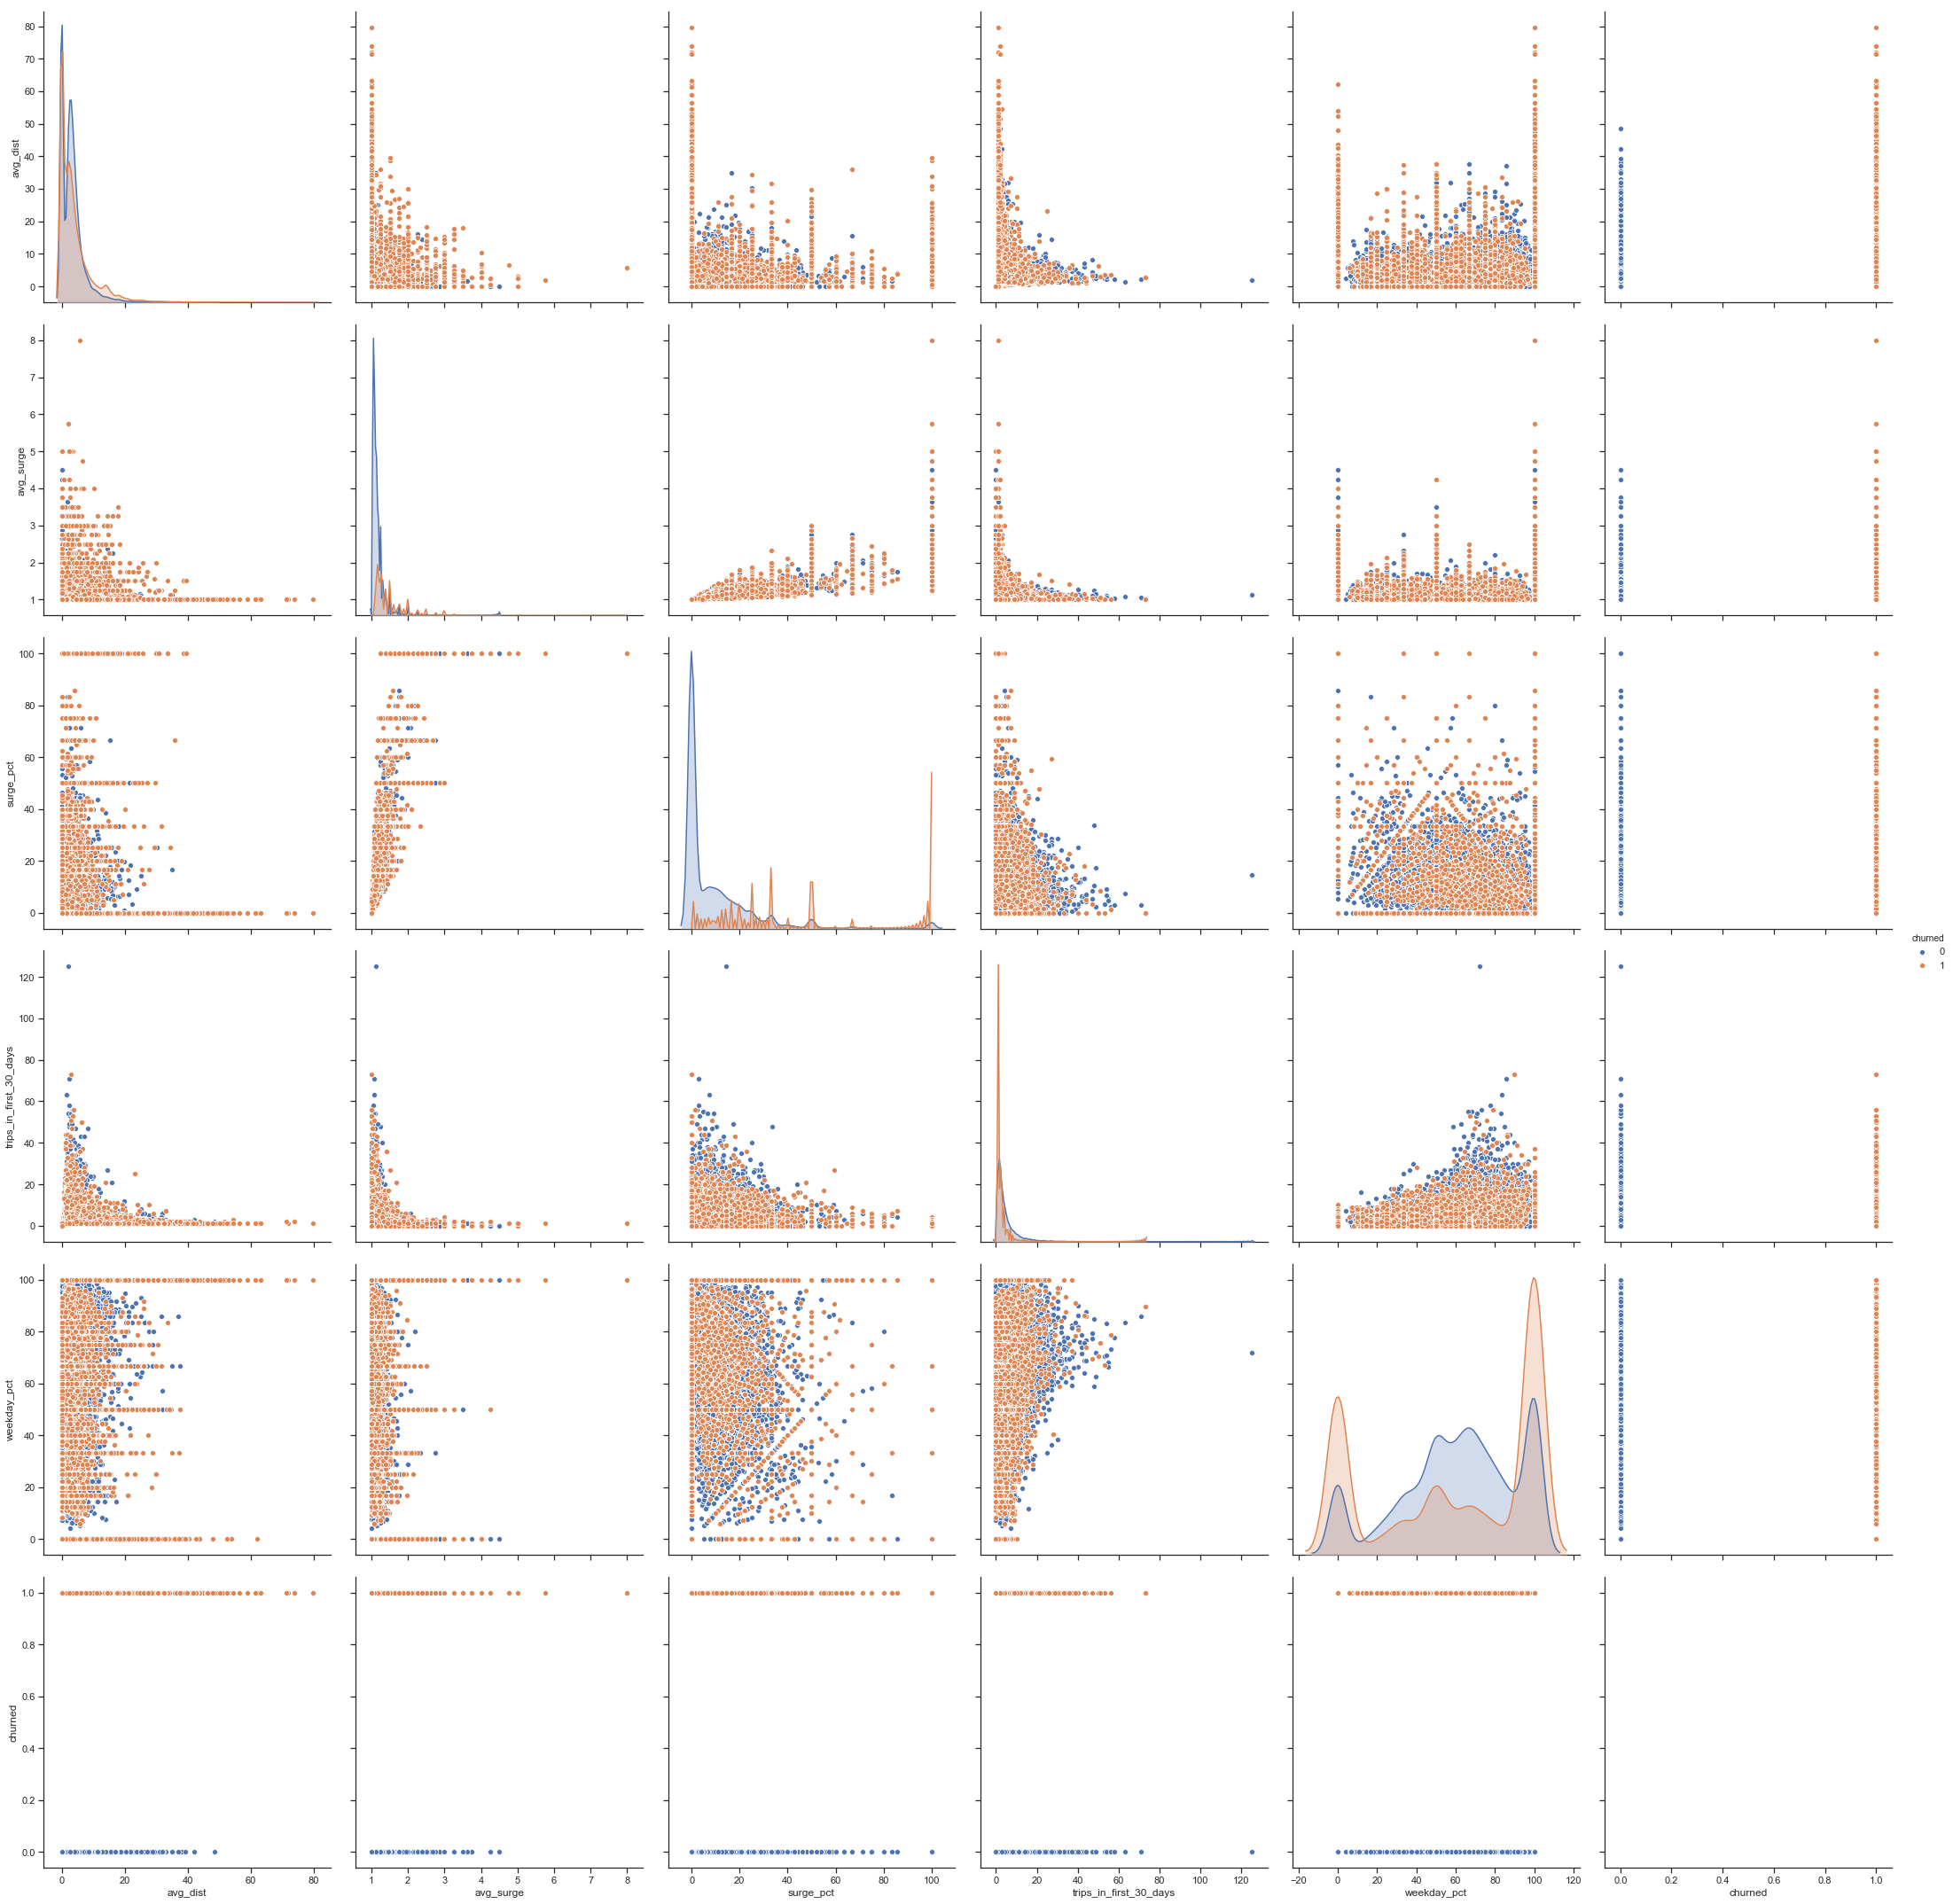

In [41]:
sns.set(style = "ticks",color_codes = True)
cols = cont_cols[0:]
cols.append("churned")
plt.figure(figsize = (10,5))
sns.pairplot(data[cols],hue = "churned",height =5)
plt.show()

- Surge_pct should be a good predictor. Customers who churned have generally experienced higher % of rides with surge.
- There seems to be some correlation between surge_pct and avg_surge.

### By luxury_car_user--

<Figure size 720x360 with 0 Axes>

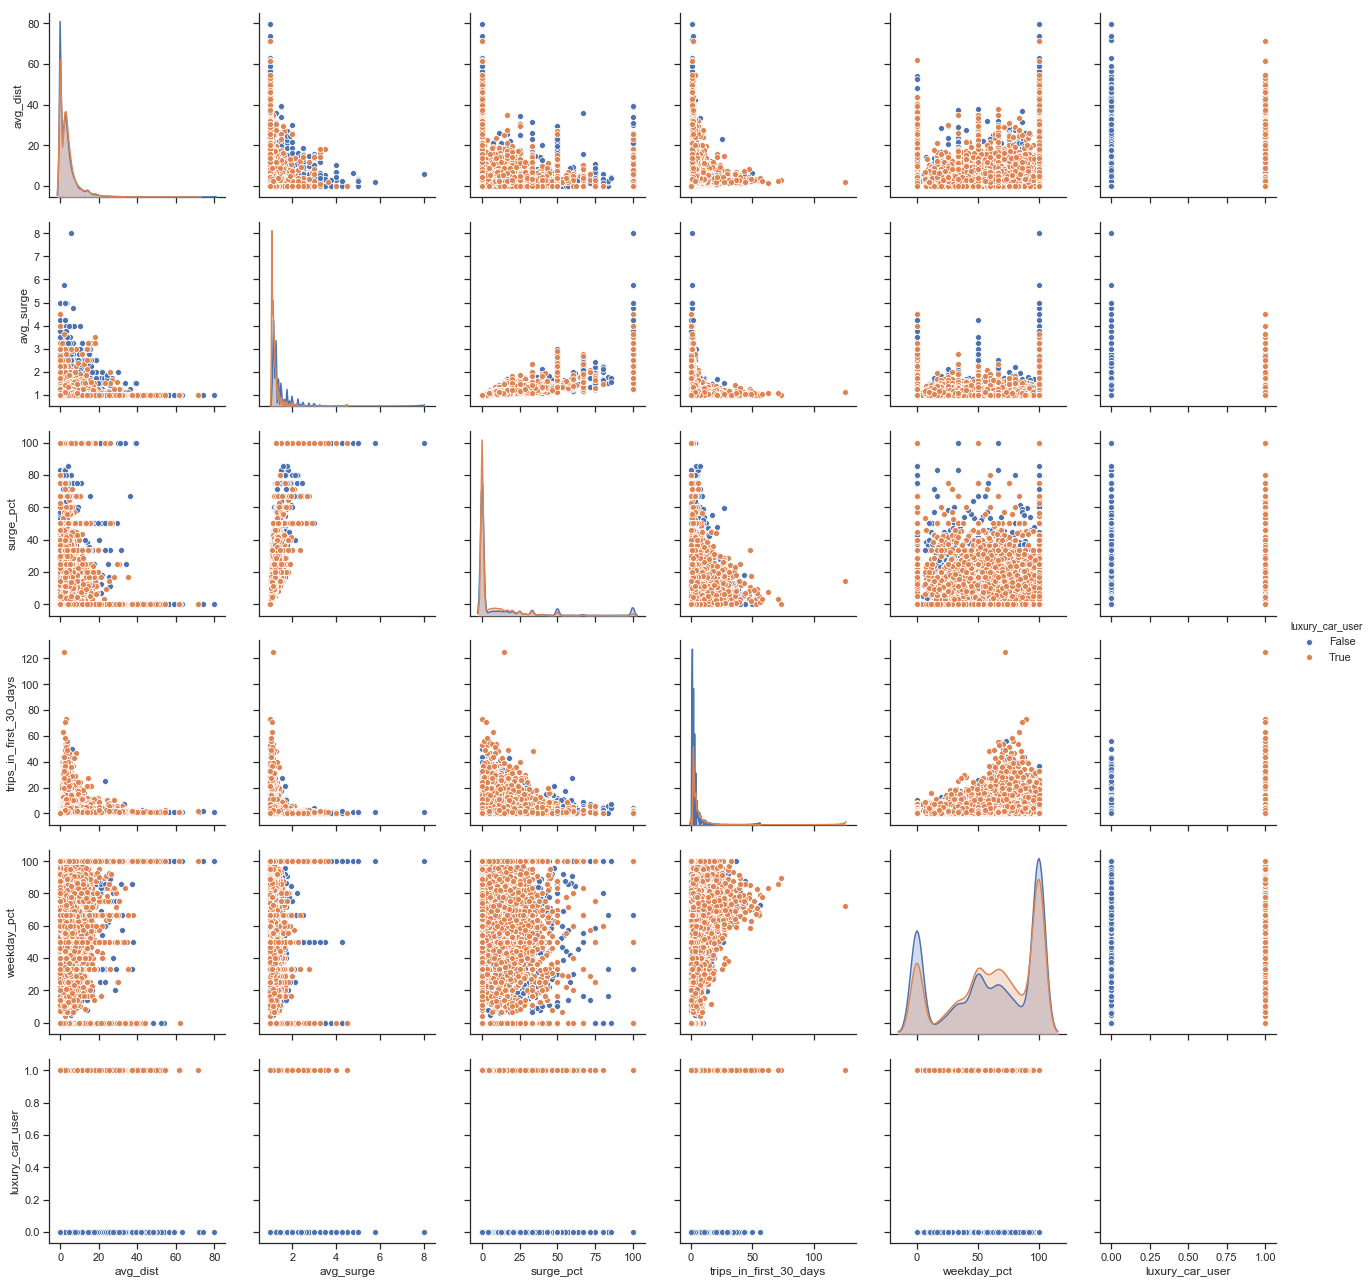

In [42]:
sns.set(style = "ticks",color_codes = True)
cols = cont_cols[0:]
cols.append("luxury_car_user")
plt.figure(figsize = (10,5))
sns.pairplot(data[cols],hue = "luxury_car_user",height =3)
plt.show()

No pattern as such

#### -  Lets look at the relationships between the categorical variables

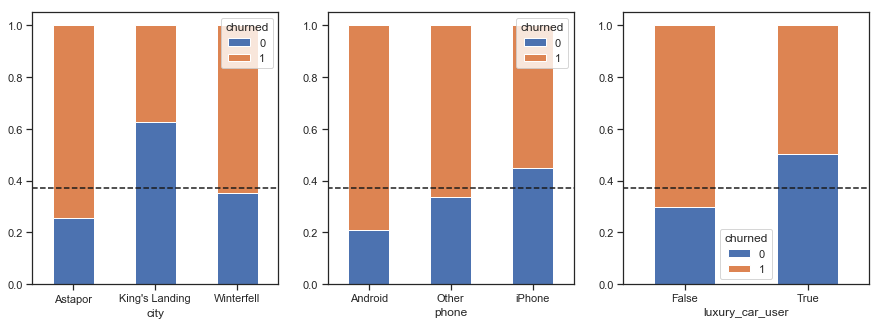

In [43]:
fig,ax = plt.subplots(1,3,figsize = (15,5))
for i in range(len(separate(data)["categorical"])-1):
    data.groupby(separate(data)["categorical"][i])["churned"].value_counts(normalize = True).unstack().plot(kind = "bar",stacked = True,rot = 0,ax = ax[i])
    ax[i].hlines(0.37,-10,100,linestyle = "dashed")
plt.show()

##### Observations
- City Astaphor is experiencing a higher churn; whereas the business is doing well in King's Landing.
- Android users are more likely to leave than iPhone customers. (there might some issue with Android UI). From pair plots, we noticed, Android users are experiencing a higher surge charge. That could be a reason.
- People who didn't use the luxury car in the first 30 days are more likely to leave.

## Correlation

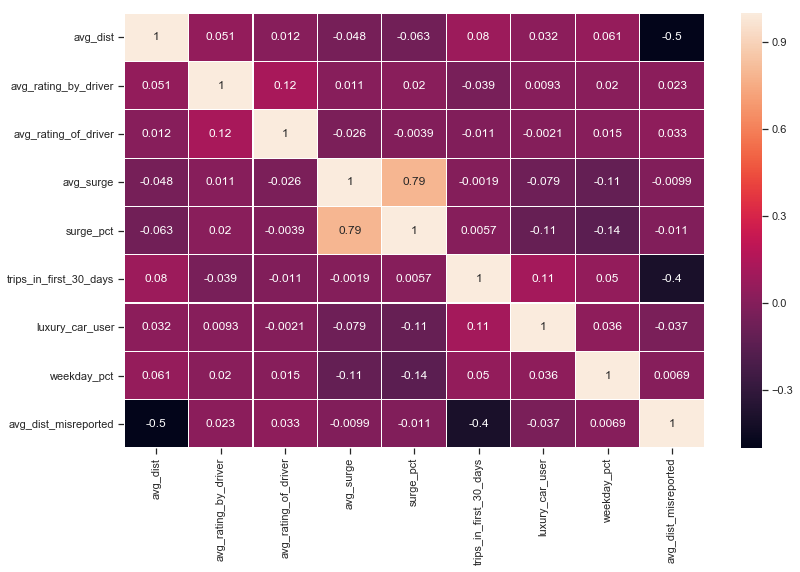

In [44]:
plt.figure(figsize = (13,8))
sns.heatmap(data.corr(),annot = True,linewidth = 0.2)
plt.show()

- Yes, that confirms. Avg_surge and surge_pct are highly correlated. Therefore, we'll only use one of these variables for modellinf (surge_pct)
- Although, very less, both the ratings seem to be correlated too.
- Similarly, weekday_pct and surge_pct are slightly negatively correlated. This makes sense. Riders experience less surge charge on weekdays.

## Feature Engineering

In [45]:
#Converting ratings into a categorical variable
data["rating_by_driver"] = ''
data.rating_by_driver[data.avg_rating_by_driver >= 4] = "good"
data.rating_by_driver[(data.avg_rating_by_driver >= 3) & (data.avg_rating_by_driver < 4)] = "okay"
data.rating_by_driver[data.avg_rating_by_driver < 3] = "bad"
data.rating_by_driver[data.avg_rating_by_driver.isnull()] = "Unkown"

C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

In [46]:
data["rating_of_driver"] = ''
data.rating_of_driver[data.avg_rating_of_driver >= 4] = "good"
data.rating_of_driver[(data.avg_rating_of_driver >= 3) & (data.avg_rating_of_driver < 4)] = "okay"
data.rating_of_driver[data.avg_rating_of_driver < 3] = "bad"
data.rating_of_driver[data.avg_rating_of_driver.isnull()] = "Unkown"

C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-co

In [47]:
#Creating a new variable - do they have an iphone?
data["have_an_android_other"] = 0
data.have_an_android_other[data.phone != "iPhone"] = 1

C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
#Having surge or not?
data["surge_or_not"] = 0
data.surge_or_not[data.avg_surge > 1] = 1

C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
data["ride_with_surge"] = ''
data.ride_with_surge[data.surge_pct == 0] = "none"
data.ride_with_surge[data.surge_pct == 100] = "all"
data.ride_with_surge[(data.surge_pct > 0) & (data.surge_pct < 100)] = "some"

C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-co

In [50]:
data["ride_during_week"] = ''
data.ride_during_week[data.weekday_pct == 0] = "none"
data.ride_during_week[data.weekday_pct == 100] = "all"
data.ride_during_week[(data.weekday_pct > 0) & (data.weekday_pct < 100)] = "some"

C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-co

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 20 columns):
avg_dist                  49992 non-null float64
avg_rating_by_driver      49791 non-null float64
avg_rating_of_driver      41873 non-null float64
avg_surge                 49992 non-null float64
city                      49992 non-null object
last_trip_date            49992 non-null datetime64[ns]
phone                     49992 non-null object
signup_date               49992 non-null datetime64[ns]
surge_pct                 49992 non-null float64
trips_in_first_30_days    49992 non-null int64
luxury_car_user           49992 non-null bool
weekday_pct               49992 non-null float64
churned                   49992 non-null category
avg_dist_misreported      49992 non-null int64
rating_by_driver          49992 non-null object
rating_of_driver          49992 non-null object
have_an_android_other     49992 non-null int64
surge_or_not              49992 non-null int64
ride_with

In [52]:
#Correcting the data_types of new variables
data.avg_dist_misreported = data.avg_dist_misreported.astype("category") 
data.have_an_android_other = data.have_an_android_other.astype("category")
data.surge_or_not = data.surge_or_not.astype("category")

In [53]:
#Creating dummy variables
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 20 columns):
avg_dist                  49992 non-null float64
avg_rating_by_driver      49791 non-null float64
avg_rating_of_driver      41873 non-null float64
avg_surge                 49992 non-null float64
city                      49992 non-null object
last_trip_date            49992 non-null datetime64[ns]
phone                     49992 non-null object
signup_date               49992 non-null datetime64[ns]
surge_pct                 49992 non-null float64
trips_in_first_30_days    49992 non-null int64
luxury_car_user           49992 non-null bool
weekday_pct               49992 non-null float64
churned                   49992 non-null category
avg_dist_misreported      49992 non-null category
rating_by_driver          49992 non-null object
rating_of_driver          49992 non-null object
have_an_android_other     49992 non-null category
surge_or_not              49992 non-null category


In [54]:
data = pd.get_dummies(data, drop_first = True,columns = ["city","phone","ride_with_surge","ride_during_week","rating_by_driver","rating_of_driver"])

In [55]:
data = sm.add_constant(data)

C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


This makes our EDA process complete. Before, moving on to the modelling phase, lets split our training set into train and test sets

# Modelling

In [56]:
#We already converted ratings into categories; avg_surge and surge_pct(highly correlated - using only one!); dates dont make sense
drop_columns = ["avg_rating_by_driver","avg_rating_of_driver","avg_surge","last_trip_date","signup_date","churned"]
features = [i for i in list(data.columns) if i not in drop_columns]

In [57]:
X_train,X_test,y_train,y_test = train_test_split(data[features],data["churned"],test_size = 0.2,random_state = 42)

In [58]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39993 entries, 22305 to 15796
Data columns (total 23 columns):
const                     39993 non-null float64
avg_dist                  39993 non-null float64
surge_pct                 39993 non-null float64
trips_in_first_30_days    39993 non-null int64
luxury_car_user           39993 non-null bool
weekday_pct               39993 non-null float64
avg_dist_misreported      39993 non-null category
have_an_android_other     39993 non-null category
surge_or_not              39993 non-null category
city_King's Landing       39993 non-null uint8
city_Winterfell           39993 non-null uint8
phone_Other               39993 non-null uint8
phone_iPhone              39993 non-null uint8
ride_with_surge_none      39993 non-null uint8
ride_with_surge_some      39993 non-null uint8
ride_during_week_none     39993 non-null uint8
ride_during_week_some     39993 non-null uint8
rating_by_driver_bad      39993 non-null uint8
rating_by_driver_good    

# EVALUATION METRICS

- Since, the target is to predict churners correctly, we'll focus more on getting True Positive correct (High TPR). We can let off False Positive errors (Customers we predicted will churn, but do not!) as they are not that important.
- Also, we need to lower the False Negative error (Customers we predicted will not churn, but they did churn!). In this case, we might lose these customers due to the error.

#### So, our main target would be to - MAXIMIZE TRUE POSITIVES and MINIMIZE FALSE NEGATIVE ERRORS!

#### Metrics we'll look at:
- Confusion Matrix
- ROC-AUC curve


### Model Comparison Metrics

In [59]:
def cross_validation(model,xtrain,ytrain, scoretype, folds):
    scores = cross_val_score(estimator = model,X= xtrain, y = ytrain,scoring = scoretype,cv = folds)
    print("%s: %0.3f (+/- %0.2f)" % ("roc-auc",scores.mean(),scores.std()))
    
    
def roc_truth(model,Xtest,ytest,low = 0.0,high = 0.1):
    fpr, tpr, threshold = metrics.roc_curve(ytest,model.predict_proba(Xtest)[:,1])
    max_lst = []
    for idx,i in enumerate(fpr):
        if low <= i <= high:
            max_lst.append([tpr[idx],fpr[idx],threshold[idx]])
    return np.around(max(max_lst,key = lambda x:x[0]),2)
       
def roc_curve(X_test,y_test,model,model_name,high = 0.1):
    from sklearn import metrics
    roc_auc = metrics.roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    fpr,tpr,threshold = metrics.roc_curve(y_test,model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr,tpr,label = "Model:" + model_name +(" (AUC) = %0.2f")%roc_auc)
    plt.plot([0,1],[0,1],"r--")
    truth = list(roc_truth(model,X_test,y_test,high = high))
    x,y = truth[1],truth[0]
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot(x,y,'or')
    plt.legend(loc = "lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.show()
    
def capcurve(y_test,prob,set_name,percent = 0.5):
    df = pd.concat([y_test,prob],axis =1).reset_index()
    df.columns = ["row_number","churned","prob"]
    df = df.sort_values(by = ["prob"],ascending = False)
    df = df.reset_index()
    total_exited = sum(df.churned)
    total_records = len(df)
    percent_exited = total_exited/total_records
    cols = ["total_records","total","RandomSelect","RandomSelectPercentOfTotalChurners","ModelSelect","ModelSelectPercentofTotalChurners"]
    table = pd.DataFrame(columns = cols)
    table.total_records = range(1,len(df)+1)
    table.total = round((table.total_records/total_records),2)
    table.RandomSelect = table.total_records*percent_exited
    table.RandomSelectPercentOfTotalChurners = round((table.RandomSelect/total_exited),2)
    table.ModelSelect = df.churned.astype("int")
    table.ModelSelect = table.ModelSelect.cumsum()
    table.ModelSelectPercentofTotalChurners = round((table.ModelSelect/total_exited),2)
    
    #percent = 0.7
    half = np.trunc(total_records*percent).astype("int")
    y1 = table.ModelSelectPercentofTotalChurners[half]
    y2 = table.ModelSelectPercentofTotalChurners[half+1]
    if y1 == y2:
        val =y1*1.0
    else:
        x1 = table.RandomSelectPercentOfTotalChurners[half]
        x2 = table.RandomSelectPercentOfTotalChurners[half+1]
        val = y1 + ((x2-percent)/(x2 - x1)) * (y2 -y1)
    fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize = (15,5))
    ax.plot(table.total,table.ModelSelectPercentofTotalChurners,label = "User Model " + set_name + " set")
    ax.plot(table.total,table.RandomSelectPercentOfTotalChurners,label = "Random Model")
    ax.plot([percent, percent], [0.0, val], color='green', linestyle='--', linewidth=1)
    ax.plot([0.0, percent], [val, val], color='green', linestyle='--', linewidth=1,label = str(round(val*100,2)) + "% obs. of churners at " + str(percent*100) + "% customers")
    plt.title("Cumulative Accuracy Profile (CAP)")
    plt.xlim(0,1.0)
    plt.ylim(0,1.0)
    plt.xlabel("% of data")
    plt.ylabel("% of churners")
    plt.legend()
    plt.show()

### - Before, moving on, lets see if we can use PCA to determine what algorithm might work here!

In [60]:
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(X_train)

In [61]:
pca_df = pd.DataFrame(data = principal_components,columns = ['PCA1','PCA2'])
pca_df = pd.concat([pca_df,y_train.reset_index(drop = True)],axis =1)

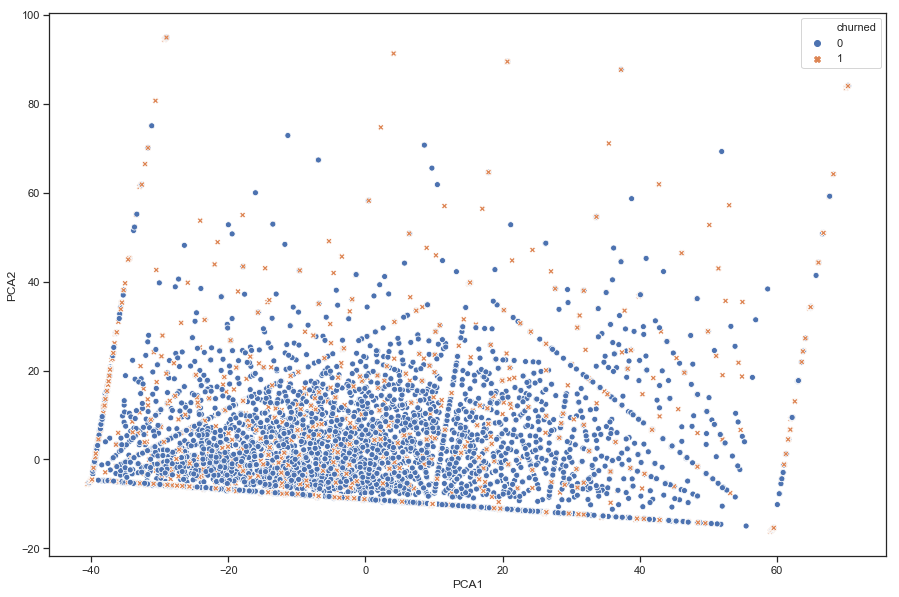

In [62]:
plt.figure(figsize = (15,10))
sns.scatterplot(pca_df['PCA1'],pca_df['PCA2'],hue = pca_df["churned"],style = pca_df["churned"])
plt.legend(loc = 'upper right')
plt.show()

The two classes are definitely not linearly separable...

## LOGISTIC REGRESSION

Since, logistic regression doesn't automatically identify best features, lets try backward elimination method to find the best subset of features.

In [63]:
X_train2 = X_train.copy()

In [64]:
log1 = sm.Logit(y_train,X_train2.astype("float")).fit()
log1.summary2()

Optimization terminated successfully.
         Current function value: 0.486465
         Iterations 12


C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.265     
Dependent Variable:   churned            AIC:                38954.3503
Date:                 2020-06-01 07:47   BIC:                39143.4724
No. Observations:     39993              Log-Likelihood:     -19455.   
Df Model:             21                 LL-Null:            -26462.   
Df Residuals:         39971              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       12.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
const                  -0.2143      nan      nan    nan     nan     nan
avg_dist                0.0263   0.0035   7.4892 0.0000  0.0194  0.0332
surge_pct               0.0375   0.0017  22.5001 0.0000  0.0342  0.0407
trips_in_first_30_days -0.0171   0.0044  -3.9057 0.0001 -0.0257 -0.0085
luxury_car_user        -0.7910   0.0259 -30.5289 0.0000 -0.8418 -0.7402
weekday_pct            -0.0074   0.0009  -8.2792 0.0000 -0.0091 -0.0056
avg_dist_misreported   -0.4866   0.0370 -13.1630 0.0000 -0.5590 -0.4141
have_an_android_other   0.4224      nan      nan    nan     nan     nan
surge_or_not            0.2573   0.5157   0.4989 0.6178 -0.7534  1.2680
city_King's Landing    -1.7790   0.0361 -49.2505 0.0000 -1.8498 -1.7082
city_Winterfell        -0.5849   0.0297 -19.6873 0.0000 -0.6432 -0.5267
phone_Other            -0.5890   0.1449  -4.0650 0.0000 -0.8730 -0.3050
phone_iPhone           -0.6366      nan      nan    nan     nan     nan
ride_with_surge_none    3.9892   0.5417   7.3646 0.0000  2.9275  5.0508
ride_with_surge_some    2.0118   0.1581  12.7239 0.0000  1.7019  2.3217
ride_during_week_none  -0.6560   0.0978  -6.7105 0.0000 -0.8476 -0.4644
ride_during_week_some  -1.6241   0.0516 -31.4795 0.0000 -1.7252 -1.5229
rating_by_driver_bad    0.3500   0.2914   1.2012 0.2297 -0.2211  0.9211
rating_by_driver_good  -0.0599   0.2188  -0.2737 0.7843 -0.4888  0.3690
rating_by_driver_okay   0.2165   0.2343   0.9237 0.3556 -0.2428  0.6757
rating_of_driver_bad    0.1320   0.1176   1.1230 0.2614 -0.0984  0.3625
rating_of_driver_good  -0.0864   0.0398  -2.1727 0.0298 -0.1644 -0.0085
rating_of_driver_okay  -0.1800   0.0612  -2.9417 0.0033 -0.2999 -0.0601
=======================================================================

"""

We have 5 variables that are out of our 95% confidence interval. Rating_by_driver_good has highest p_value. Lets remove that variable first. (The NaN values appear due to presence of multi-collinear/non-important variables in the model)

In [65]:
X_train2.drop(columns = ["rating_by_driver_good"],inplace = True)

In [66]:
log2 = sm.Logit(y_train,X_train2.astype("float")).fit()
log2.summary2()

Optimization terminated successfully.
         Current function value: 0.486465
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.265     
Dependent Variable:   churned            AIC:                38952.4260
Date:                 2020-06-01 07:47   BIC:                39132.9516
No. Observations:     39993              Log-Likelihood:     -19455.   
Df Model:             20                 LL-Null:            -26462.   
Df Residuals:         39972              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       7.0000                                           
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
const                  -0.2526      nan      nan    nan     nan     nan
avg_dist                0.0263   0.0035   7.4866 0.0000  0.0194  0.0332
surge_pct               0.0375   0.0017  22.4984 0.0000  0.0342  0.0407
trips_in_first_30_days -0.0171   0.0044  -3.9066 0.0001 -0.0257 -0.0085
luxury_car_user        -0.7911   0.0259 -30.5386 0.0000 -0.8419 -0.7404
weekday_pct            -0.0074   0.0009  -8.2792 0.0000 -0.0091 -0.0056
avg_dist_misreported   -0.4866   0.0370 -13.1640 0.0000 -0.5591 -0.4142
have_an_android_other   0.4031      nan      nan    nan     nan     nan
surge_or_not            0.2573   0.5157   0.4989 0.6178 -0.7534  1.2680
city_King's Landing    -1.7789   0.0361 -49.2507 0.0000 -1.8497 -1.7081
city_Winterfell        -0.5849   0.0297 -19.6858 0.0000 -0.6431 -0.5266
phone_Other            -0.5885   0.1449  -4.0625 0.0000 -0.8725 -0.3046
phone_iPhone           -0.6558      nan      nan    nan     nan     nan
ride_with_surge_none    3.9873   0.5416   7.3616 0.0000  2.9257  5.0489
ride_with_surge_some    2.0099   0.1580  12.7231 0.0000  1.7003  2.3195
ride_during_week_none  -0.6558   0.0978  -6.7084 0.0000 -0.8474 -0.4642
ride_during_week_some  -1.6243   0.0516 -31.4898 0.0000 -1.7254 -1.5232
rating_by_driver_bad    0.4094   0.1945   2.1044 0.0353  0.0281  0.7907
rating_by_driver_okay   0.2761   0.0862   3.2026 0.0014  0.1071  0.4451
rating_of_driver_bad    0.1322   0.1176   1.1245 0.2608 -0.0982  0.3626
rating_of_driver_good  -0.0866   0.0398  -2.1762 0.0295 -0.1645 -0.0086
rating_of_driver_okay  -0.1801   0.0612  -2.9444 0.0032 -0.3001 -0.0602
=======================================================================

"""

p-values have changed for many variables who were earlier not significant. Also, although slightly, our AIC value has decreased.

- Lets remove surge_or_not now.

In [67]:
X_train2.drop(columns = ["surge_or_not"],inplace = True)

In [68]:
log3 = sm.Logit(y_train,X_train2.astype("float")).fit()
log3.summary2()

Optimization terminated successfully.
         Current function value: 0.486469
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.265     
Dependent Variable:   churned            AIC:                38950.6871
Date:                 2020-06-01 07:47   BIC:                39122.6163
No. Observations:     39993              Log-Likelihood:     -19455.   
Df Model:             19                 LL-Null:            -26462.   
Df Residuals:         39973              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
const                  -0.0833      nan      nan    nan     nan     nan
avg_dist                0.0263   0.0035   7.4858 0.0000  0.0194  0.0332
surge_pct               0.0375   0.0017  22.5468 0.0000  0.0342  0.0408
trips_in_first_30_days -0.0172   0.0044  -3.9430 0.0001 -0.0258 -0.0087
luxury_car_user        -0.7912   0.0259 -30.5403 0.0000 -0.8419 -0.7404
weekday_pct            -0.0074   0.0009  -8.2874 0.0000 -0.0091 -0.0056
avg_dist_misreported   -0.4870   0.0370 -13.1751 0.0000 -0.5594 -0.4145
have_an_android_other   0.4878      nan      nan    nan     nan     nan
city_King's Landing    -1.7790   0.0361 -49.2505 0.0000 -1.8498 -1.7082
city_Winterfell        -0.5850   0.0297 -19.6886 0.0000 -0.6432 -0.5267
phone_Other            -0.5882   0.1449  -4.0601 0.0000 -0.8722 -0.3043
phone_iPhone           -0.5710      nan      nan    nan     nan     nan
ride_with_surge_none    3.7341   0.1880  19.8600 0.0000  3.3656  4.1027
ride_with_surge_some    2.0127   0.1579  12.7476 0.0000  1.7033  2.3222
ride_during_week_none  -0.6564   0.0977  -6.7158 0.0000 -0.8480 -0.4649
ride_during_week_some  -1.6244   0.0516 -31.4916 0.0000 -1.7255 -1.5233
rating_by_driver_bad    0.4094   0.1945   2.1043 0.0354  0.0281  0.7907
rating_by_driver_okay   0.2760   0.0862   3.2017 0.0014  0.1070  0.4450
rating_of_driver_bad    0.1323   0.1176   1.1249 0.2606 -0.0982  0.3627
rating_of_driver_good  -0.0865   0.0398  -2.1749 0.0296 -0.1645 -0.0085
rating_of_driver_okay  -0.1801   0.0612  -2.9438 0.0032 -0.3000 -0.0602
=======================================================================

"""

AIC value drops further.

In [69]:
X_train2.drop(columns = ["rating_of_driver_bad"],inplace = True)

In [70]:
log4 = sm.Logit(y_train,X_train2.astype("float")).fit()
log4.summary2()

Optimization terminated successfully.
         Current function value: 0.486485
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: Logit
=====================================================================================
Model:                      Logit                  Pseudo R-squared:       0.265     
Dependent Variable:         churned                AIC:                    38949.9670
Date:                       2020-06-01 07:47       BIC:                    39113.2997
No. Observations:           39993                  Log-Likelihood:         -19456.   
Df Model:                   18                     LL-Null:                -26462.   
Df Residuals:               39974                  LLR p-value:            0.0000    
Converged:                  1.0000                 Scale:                  1.0000    
No. Iterations:             8.0000                                                   
-------------------------------------------------------------------------------------
                        Coef.    Std.Err.     z     P>|z|      [0.025       0.975]   
-------------------------------------------------------------------------------------
const                  -0.0769 814411.9401  -0.0000 1.0000 -1596218.1480 1596217.9942
avg_dist                0.0262      0.0035   7.4694 0.0000        0.0194       0.0331
surge_pct               0.0375      0.0017  22.5595 0.0000        0.0343       0.0408
trips_in_first_30_days -0.0172      0.0044  -3.9411 0.0001       -0.0258      -0.0087
luxury_car_user        -0.7912      0.0259 -30.5419 0.0000       -0.8420      -0.7404
weekday_pct            -0.0074      0.0009  -8.2973 0.0000       -0.0092      -0.0057
avg_dist_misreported   -0.4881      0.0369 -13.2100 0.0000       -0.5605      -0.4157
have_an_android_other   0.4907 814411.9401   0.0000 1.0000 -1596217.5804 1596218.5618
city_King's Landing    -1.7791      0.0361 -49.2556 0.0000       -1.8499      -1.7083
city_Winterfell        -0.5844      0.0297 -19.6742 0.0000       -0.6427      -0.5262
phone_Other            -0.5897      0.1449  -4.0703 0.0000       -0.8737      -0.3058
phone_iPhone           -0.5676 814411.9401  -0.0000 1.0000 -1596218.6387 1596217.5035
ride_with_surge_none    3.7370      0.1880  19.8784 0.0000        3.3686       4.1055
ride_with_surge_some    2.0154      0.1579  12.7665 0.0000        1.7060       2.3248
ride_during_week_none  -0.6579      0.0977  -6.7312 0.0000       -0.8494      -0.4663
ride_during_week_some  -1.6226      0.0516 -31.4740 0.0000       -1.7236      -1.5215
rating_by_driver_bad    0.4139      0.1945   2.1285 0.0333        0.0328       0.7950
rating_by_driver_okay   0.2797      0.0861   3.2472 0.0012        0.1109       0.4486
rating_of_driver_good  -0.0993      0.0382  -2.6000 0.0093       -0.1742      -0.0244
rating_of_driver_okay  -0.1934      0.0601  -3.2184 0.0013       -0.3111      -0.0756
=====================================================================================

"""

AIC value drops further. And, our Nan values have converged and are equal to 1.0. At this point, we can try and remove tht two variables individually, and see AIC values. (Ignoring constant - we should always include constant in the model)

In [71]:
X_train_temp = X_train2.copy()
X_train_temp.drop(columns = ["have_an_android_other"],inplace = True)
log5 = sm.Logit(y_train,X_train_temp.astype("float")).fit()
log5.summary2()

Optimization terminated successfully.
         Current function value: 0.486485
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.265     
Dependent Variable:   churned            AIC:                38949.9670
Date:                 2020-06-01 07:47   BIC:                39113.2997
No. Observations:     39993              Log-Likelihood:     -19456.   
Df Model:             18                 LL-Null:            -26462.   
Df Residuals:         39974              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
const                   0.4138   0.2206   1.8754 0.0607 -0.0187  0.8462
avg_dist                0.0262   0.0035   7.4694 0.0000  0.0194  0.0331
surge_pct               0.0375   0.0017  22.5595 0.0000  0.0343  0.0408
trips_in_first_30_days -0.0172   0.0044  -3.9411 0.0001 -0.0258 -0.0087
luxury_car_user        -0.7912   0.0259 -30.5419 0.0000 -0.8420 -0.7404
weekday_pct            -0.0074   0.0009  -8.2973 0.0000 -0.0092 -0.0057
avg_dist_misreported   -0.4881   0.0369 -13.2100 0.0000 -0.5605 -0.4157
city_King's Landing    -1.7791   0.0361 -49.2556 0.0000 -1.8499 -1.7083
city_Winterfell        -0.5844   0.0297 -19.6742 0.0000 -0.6427 -0.5262
phone_Other            -0.5897   0.1449  -4.0703 0.0000 -0.8737 -0.3058
phone_iPhone           -1.0583   0.0297 -35.5804 0.0000 -1.1166 -1.0000
ride_with_surge_none    3.7370   0.1880  19.8784 0.0000  3.3686  4.1055
ride_with_surge_some    2.0154   0.1579  12.7665 0.0000  1.7060  2.3248
ride_during_week_none  -0.6579   0.0977  -6.7312 0.0000 -0.8494 -0.4663
ride_during_week_some  -1.6226   0.0516 -31.4740 0.0000 -1.7236 -1.5215
rating_by_driver_bad    0.4139   0.1945   2.1285 0.0333  0.0328  0.7950
rating_by_driver_okay   0.2797   0.0861   3.2472 0.0012  0.1109  0.4486
rating_of_driver_good  -0.0993   0.0382  -2.6000 0.0093 -0.1742 -0.0244
rating_of_driver_okay  -0.1934   0.0601  -3.2184 0.0013 -0.3111 -0.0756
=======================================================================

"""

Our AIC value is the same. P-values have dropped for the other variables (Although, it is still high for constant.)

In [72]:
X_train_temp = X_train2.copy()
X_train_temp.drop(columns = ["phone_iPhone"],inplace = True)
log6 = sm.Logit(y_train,X_train_temp.astype("float")).fit()
log6.summary2()

Optimization terminated successfully.
         Current function value: 0.486485
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.265     
Dependent Variable:   churned            AIC:                38949.9670
Date:                 2020-06-01 07:47   BIC:                39113.2997
No. Observations:     39993              Log-Likelihood:     -19456.   
Df Model:             18                 LL-Null:            -26462.   
Df Residuals:         39974              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
const                  -0.6445   0.2196  -2.9355 0.0033 -1.0748 -0.2142
avg_dist                0.0262   0.0035   7.4694 0.0000  0.0194  0.0331
surge_pct               0.0375   0.0017  22.5595 0.0000  0.0343  0.0408
trips_in_first_30_days -0.0172   0.0044  -3.9411 0.0001 -0.0258 -0.0087
luxury_car_user        -0.7912   0.0259 -30.5419 0.0000 -0.8420 -0.7404
weekday_pct            -0.0074   0.0009  -8.2973 0.0000 -0.0092 -0.0057
avg_dist_misreported   -0.4881   0.0369 -13.2100 0.0000 -0.5605 -0.4157
have_an_android_other   1.0583   0.0297  35.5804 0.0000  1.0000  1.1166
city_King's Landing    -1.7791   0.0361 -49.2556 0.0000 -1.8499 -1.7083
city_Winterfell        -0.5844   0.0297 -19.6742 0.0000 -0.6427 -0.5262
phone_Other            -0.5897   0.1449  -4.0703 0.0000 -0.8737 -0.3058
ride_with_surge_none    3.7370   0.1880  19.8784 0.0000  3.3686  4.1055
ride_with_surge_some    2.0154   0.1579  12.7665 0.0000  1.7060  2.3248
ride_during_week_none  -0.6579   0.0977  -6.7312 0.0000 -0.8494 -0.4663
ride_during_week_some  -1.6226   0.0516 -31.4740 0.0000 -1.7236 -1.5215
rating_by_driver_bad    0.4139   0.1945   2.1285 0.0333  0.0328  0.7950
rating_by_driver_okay   0.2797   0.0861   3.2472 0.0012  0.1109  0.4486
rating_of_driver_good  -0.0993   0.0382  -2.6000 0.0093 -0.1742 -0.0244
rating_of_driver_okay  -0.1934   0.0601  -3.2184 0.0013 -0.3111 -0.0756
=======================================================================

"""

Our AIC values are same, but all the p-values now are significant! We can use this as our final subset of features. Lets use them to build our final Logistic Regression Model

In [80]:
X_train2 = X_train_temp.copy()
log_model = LogisticRegression()
log_model.fit(X_train2, y_train)

LogisticRegression()

Accuracy @50% threshold: 0.7644764476447645
roc-auc: 0.826 (+/- 0.01)


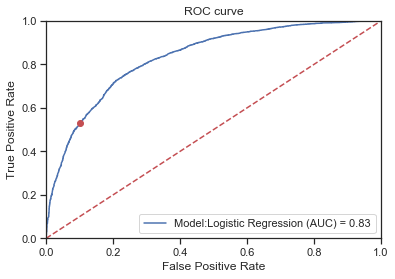

Maximum TPR under a maximum of 10% @FPR
Output = [tpr,fpr,threshold]
[0.53, 0.1, 0.79]


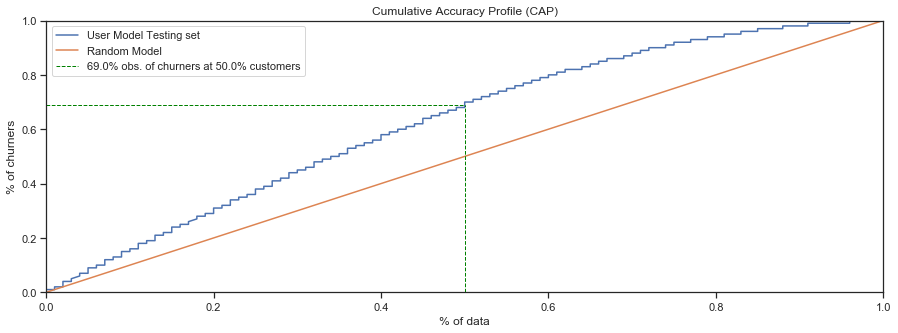

In [81]:
predictions = log_model.predict(X_test[X_train2.columns])
print("Accuracy @50% threshold:",metrics.accuracy_score(y_test,predictions))
cross_validation(log_model,X_train2,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test[X_train2.columns],y_test,log_model,"Logistic Regression",high = 0.1)
print("Maximum TPR under a maximum of 10% @FPR")
print("Output = [tpr,fpr,threshold]")
print(list(roc_truth(log_model,X_test[X_train2.columns],y_test,high = 0.1)))
capcurve(y_test.reset_index(drop = True),pd.Series(log_model.predict_proba(X_test[list(X_train2.columns)])[:,1]),"Testing")

## Decision Tree

In [82]:
X_train2 = X_train.copy()
dtree = DecisionTreeClassifier(random_state = 42)
dtree.fit(X_train2,y_train)

DecisionTreeClassifier(random_state=42)

Accuracy @50% threshold: 0.727972797279728
roc-auc: 0.708 (+/- 0.01)


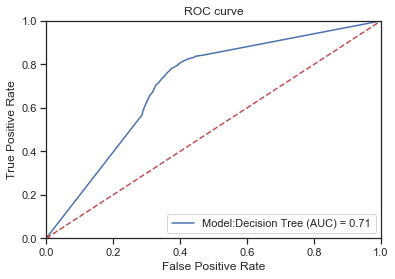

Maximum TPR under a maximum of 10% @FPR
Output = [tpr,fpr,threshold]
[0.0, 0.0, 2.0]


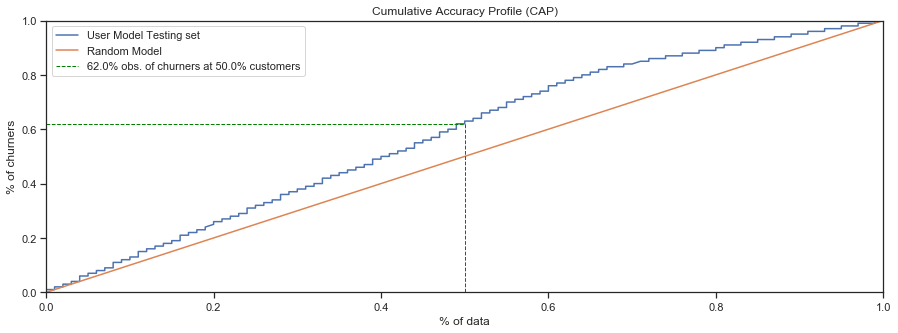

In [83]:
predictions = dtree.predict(X_test[X_train2.columns])
print("Accuracy @50% threshold:",metrics.accuracy_score(y_test,predictions))
cross_validation(dtree,X_train2,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test[X_train2.columns],y_test,dtree,"Decision Tree",high = 0.1)
print("Maximum TPR under a maximum of 10% @FPR")
print("Output = [tpr,fpr,threshold]")
print(list(roc_truth(dtree,X_test[X_train2.columns],y_test,high = 0.1)))
capcurve(y_test.reset_index(drop = True),pd.Series(dtree.predict_proba(X_test[list(X_train2.columns)])[:,1]),"Testing")

## Random Forest

In [84]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(oob_score = True).fit(X_train2,y_train)
rf

RandomForestClassifier(oob_score=True)

Accuracy @50% threshold: 0.7560756075607561
roc-auc: 0.815 (+/- 0.01)


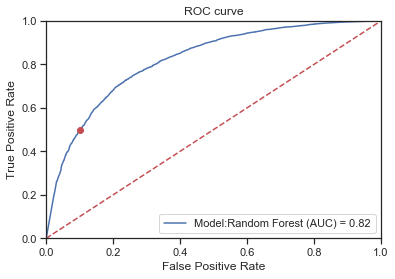

Maximum TPR under a maximum of 10% @FPR
Output = [tpr,fpr,threshold]
[0.5, 0.1, 0.86]


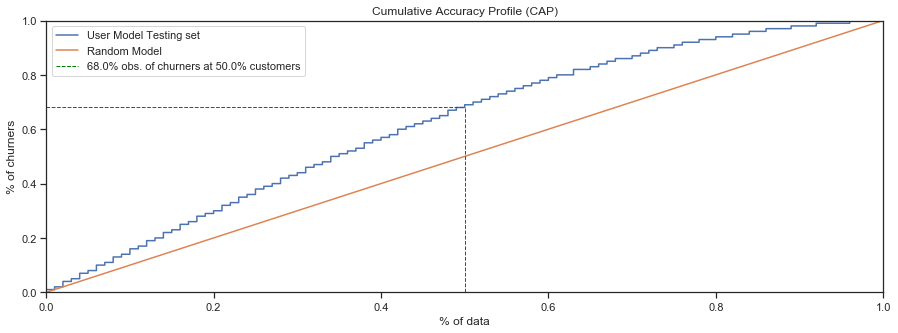

In [85]:
predictions = rf.predict(X_test[X_train2.columns])
print("Accuracy @50% threshold:",metrics.accuracy_score(y_test,predictions))
cross_validation(rf,X_train2,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test[X_train2.columns],y_test,rf,"Random Forest",high = 0.1)
print("Maximum TPR under a maximum of 10% @FPR")
print("Output = [tpr,fpr,threshold]")
print(list(roc_truth(rf,X_test[X_train2.columns],y_test,high = 0.1)))
capcurve(y_test.reset_index(drop = True),pd.Series(rf.predict_proba(X_test[list(X_train2.columns)])[:,1]),"Testing")

Comparing results for all models, the Random Forest model seems to be wroking the best. We are able to reach 68% of the churners with the Random Forest model. Also, we are able to achieve a 0.5 True Positive Rate at a maximum of 10% False positive rate. 
#Lets try and hypertune its parameters, and see if we can improve the results further.

## Model Optimization: Hyper-tuning parameters

There are two ways to hyper tune parameters:
    1. Grid Search (takes too much time - will try every combination of parameters provided)
    2. Random Search (takes less time - will try random combinations)

Random Forest has a ton of parameters to optimize. We'll hypertune the following parameters:
1. Max Depth
2. number of estimators
3. Decision Criterion
4. Maximum features
5. Minimum Samples leaf

Before, proceeding, lets see what values would be good to provide for some of the paramters. And, we'll use roc_auc score to find the best set of hyper-paramters

#### - Max_depth

In [108]:
depths = np.linspace(1,40,10,endpoint = True)
train_results = []
test_results = []
for depth in depths:
    clf = RandomForestClassifier(max_depth = depth)
    clf = clf.fit(X_train2,y_train)
    train_results.append(metrics.roc_auc_score(y_train,clf.predict(X_train2)))
    test_results.append(metrics.roc_auc_score(y_test,clf.predict(X_test)))

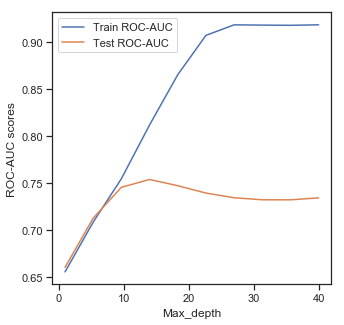

In [111]:
plt.figure(figsize = (5,5))
plt.plot(depths,train_results,label = "Train ROC-AUC")
plt.plot(depths,test_results, label = "Test ROC-AUC")
plt.legend()
plt.xlabel("Max_depth")
plt.ylabel("ROC-AUC scores")
plt.show()

Model starts to overfit as the max_depth goes beyond 10. Lets use values 0-10.

## Grid Search

In [121]:
import time
start = time.time()
clf_rf = RandomForestClassifier()
param_grid = { 'criterion' : ['gini','entropy'],
              'max_depth' : list(np.linspace(0,10,6)),
              'n_estimators' :[10,20,50,100,150,300,500],
              'min_samples_leaf':[1,2],
              'max_features':['auto',5,10]
              }
grid = GridSearchCV(estimator = clf_rf,param_grid = param_grid,n_jobs =-1,cv =5,scoring = "roc_auc")
grid.fit(X_train2,y_train)
end = time.time()

In [127]:
elapse = end- start
print("Time taken:",round(elapse,3),"seconds.")
print("Best Score:",grid.best_score_)
print("Best Parameters:",grid.best_params_)

Time taken: 2823.998 seconds.
Best Score: 0.8443050483725534
Best Parameters: {'criterion': 'entropy', 'max_depth': 10.0, 'max_features': 10, 'min_samples_leaf': 2, 'n_estimators': 300}


## Random Search

In [130]:
import time
start = time.time()
rf_tune = RandomForestClassifier()
param_grid = { 'criterion' : ['gini','entropy'],
              'max_depth' : list(np.linspace(0,10,6)),
              'n_estimators' :[10,20,50,100,150,300,500],
              'min_samples_leaf':[1,2],
              'max_features':['auto',5,10]
              }
random = RandomizedSearchCV(estimator = rf,param_distributions = param_grid,n_jobs =-1,cv = 5,scoring = "roc_auc")
random.fit(X_train2,y_train)
end = time.time()

In [132]:
elapse2 = end- start
print("Time taken:",round(elapse2,3),"seconds.")
print("Best Score:",random.best_score_)
print("Best Parameters:",random.best_params_)

Time taken: 103.519 seconds.
Best Score: 0.8440081738477113
Best Parameters: {'n_estimators': 300, 'min_samples_leaf': 1, 'max_features': 10, 'max_depth': 10.0, 'criterion': 'entropy'}


Clearly, there is a huge time difference between the two types of searches. Since, random search doesn't try all the given combinations, we might miss out on the most optimal set of parameters. But, in cases like this, when there are too many paramters to tune, its best to go with random search.

### The tuned Classifier

In [133]:
rf_tuned =  RandomForestClassifier(n_estimators = 300,criterion = 'entropy',max_depth = 10,min_samples_leaf = 2,max_features = 10)
rf_tuned.fit(X_train2,y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=10,
                       min_samples_leaf=2, n_estimators=300)

Accuracy @50% threshold: 0.7814781478147815
roc-auc: 0.844 (+/- 0.01)


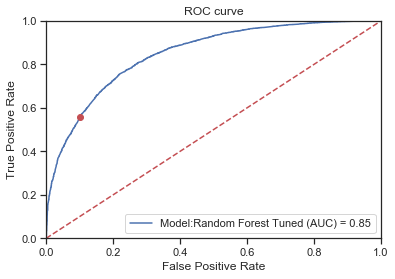

Maximum TPR under a maximum of 10% @FPR
Output = [tpr,fpr,threshold]
[0.56, 0.1, 0.78]


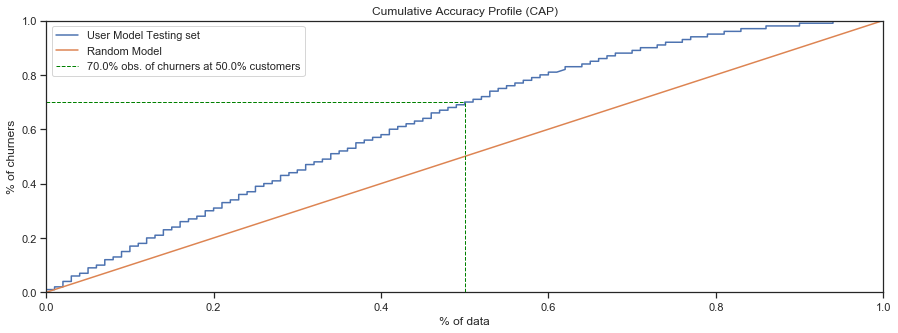

In [134]:
#Testing the tuned classifier
predictions = rf_tuned.predict(X_test[X_train2.columns])
print("Accuracy @50% threshold:",metrics.accuracy_score(y_test,predictions))
cross_validation(rf_tuned,X_train2,y_train,scoretype = "roc_auc",folds = 10)
roc_curve(X_test[X_train2.columns],y_test,rf_tuned,"Random Forest Tuned",high = 0.1)
print("Maximum TPR under a maximum of 10% @FPR")
print("Output = [tpr,fpr,threshold]")
print(list(roc_truth(rf_tuned,X_test[X_train2.columns],y_test,high = 0.1)))
capcurve(y_test.reset_index(drop = True),pd.Series(rf_tuned.predict_proba(X_test[list(X_train2.columns)])[:,1]),"Testing")

We have improved our performances. 
- We have increased our AUC to 0.85 from 0.82. 
- And True Positive Rate is now 0.56, an increase of 0.06 with a maximum false positive rate of 10%.
- And, we are able to reach 70% of customers by approaching half of the customers.

## The most important factors that drive our customer churn

In [164]:
pd.DataFrame({'features': list(X_train2.columns), 'importance': rf_tuned.feature_importances_}).sort_values('importance',ascending = False)

,features,importance
16,ride_during_week_some,0.211335
9,city_King's Landing,0.134718
2,surge_pct,0.115807
14,ride_with_surge_some,0.083488
1,avg_dist,0.067535
5,weekday_pct,0.065563
3,trips_in_first_30_days,0.062216
4,luxury_car_user,0.061904
7,have_an_android_other,0.044770
12,phone_iPhone,0.042560


In [165]:
#Another way
perm = PermutationImportance(rf_tuned, random_state=1).fit(X_test[list(X_train2.columns)], y_test)
eli5.show_weights(perm, feature_names = X_test[list(X_train2.columns)].columns.tolist())

Weight,Feature
0.1031 ± 0.0049,ride_during_week_some
0.0468 ± 0.0028,city_King's Landing
0.0247 ± 0.0033,surge_pct
0.0217 ± 0.0034,ride_with_surge_some
0.0181 ± 0.0016,luxury_car_user
0.0162 ± 0.0030,weekday_pct
0.0069 ± 0.0033,have_an_android_other
0.0066 ± 0.0013,phone_iPhone
0.0056 ± 0.0022,trips_in_first_30_days
0.0054 ± 0.0025,city_Winterfell


# Final Analysis:

We tried logistic Regression, Decision Tree and Random Forest. Random Forest gave us the best results, therefore, decided to hypertune its parameters.
By hypertuning, we were able to better our results and obtain important features such as :
1. ride_during_week_some - Customers using the app during the week
2. Customers coming from King's Landing
3. Customers experiencing surge_pct and riding with surge

These variables seem to be the most important and this information could then be used to help target specific areas within the company to make potential adjustments to decrease churn.